<a href="https://colab.research.google.com/github/quantaosun/NAMD-MD_private/blob/main/OpenMM_ABF_20220811_night.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Protein-ligand bidning free energy calculation with OpenMM: A fast, free and state-of-the-art simulation for new drug development.

### Write by quantaosun@gmail.com

#### ⚠️⚠️The very first thing is you are reminded all the content here is desined to be run on the cloud for good performance, i.e., google colab, forget your laptop, desktop or even so called workstation.

Reference

1.   http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html 
2.   https://gpantel.github.io/assets/PDF/OpenMM_Tutorial.pdf
3.   https://github.com/pablo-arantes/Making-it-rain 
4. https://docs.conda.io/en/latest/miniconda.html#linux-installers
5. https://arxiv.org/pdf/2101.07894.pdf
6. https://github.com/Gallicchio-Lab/openmm-atmmetaforce-plugin



##  Some facts

1.  People majored in medicinal chemistry can not really understand "code" or scared of it.
2. Protein-ligand binding affinity prediction is the key question in phamaceutical research.
3. In past several decades, docking has been popular due to its simplicity, but also suffers a lot with its low accuracy.
4. Molecular dynamic packages like NAMD, Gromacs, Amber, theoratically could support the calculation of binding free energy, but takes forever to setup, and finish. Some packages are not free, people need to buy.
5. OpenMM in contrast is a totallly free yet use python like interface to provide an extremely simple interface, with very fast speed.
6. This notebook is to provide you a "complete" procedure from set up to final analysis of protein-ligand binding free energy calculation.
7. You may have heard python even you havn't used it, OpenMM also use this as its application layer, making it new and easy to handle, relatively speaking.



## Theory
In the area of bidning free energy calculation.
Schodinger has released mature RBFE package known as FEP+, but not ABFE so far as in 2022.

NAMD and Gromacs can do both geometry and alchemical pathway to get the ABFE calculation, with very high pre-knowledge of molecular dynamics, being something as "advanced" that stops too many to even want to have a try.

This calculation is based on https://arxiv.org/pdf/2101.07894.pdf which adopts a new methadology which kind of combinding the geometry and alchemical pathway, also known as ATM method.

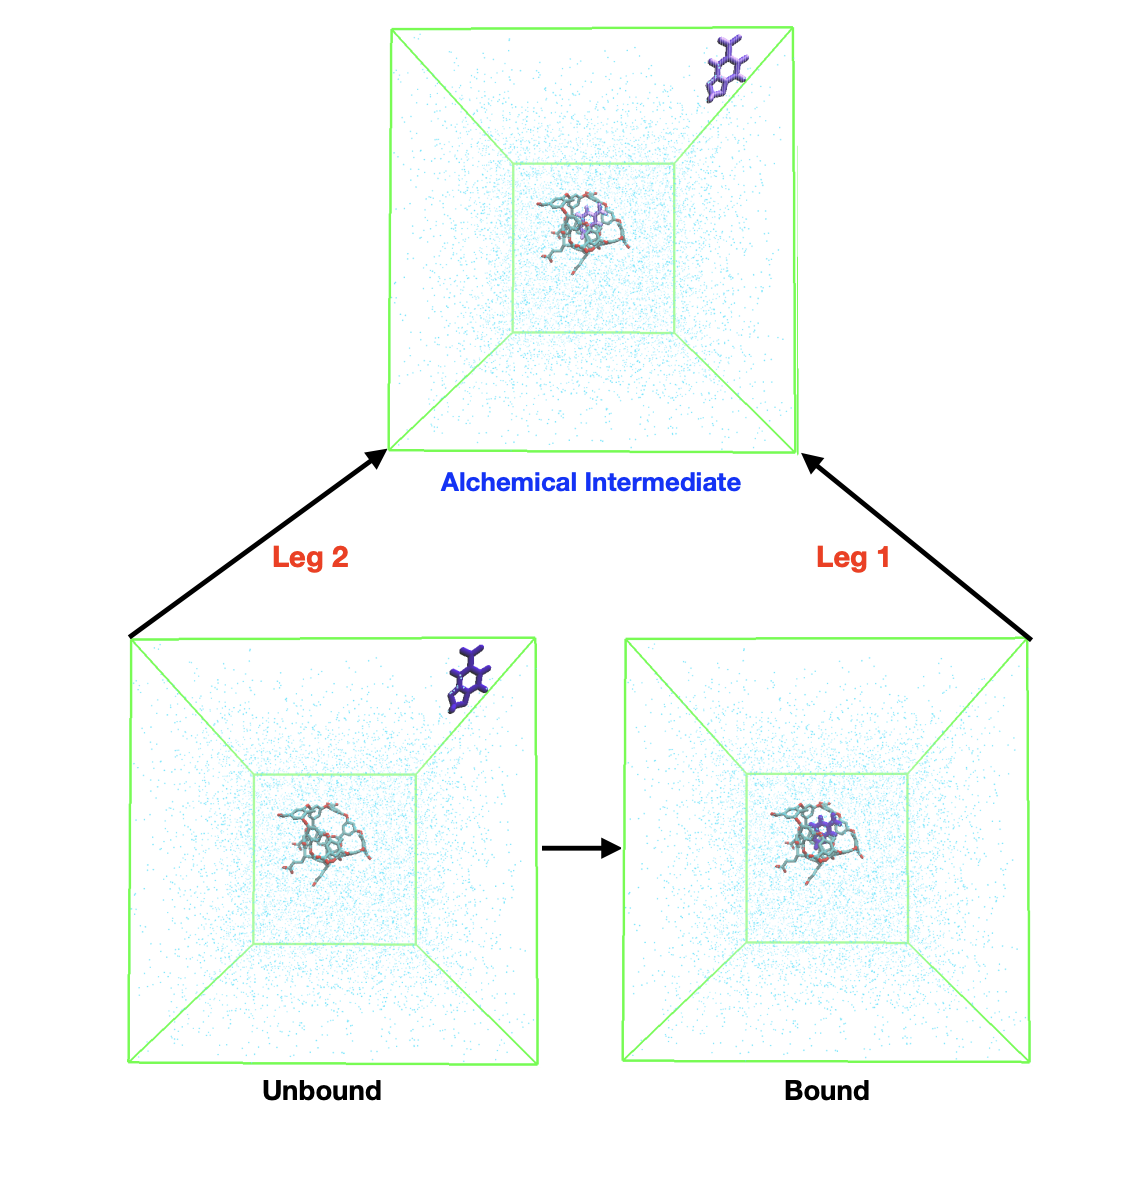

In [ ]:
from google.colab import drive
drive.flush_and_unmount
drive.mount('/content/drive',force_remount=True)

In [ ]:
# Select GPU environment

In [ ]:
# Install conda in Linux, set the python = 3.7
# Install openmm 7.7 from conda-forge
# Install openATM from conda-forge
# Git clone example
# python abfe.py

In [ ]:
!apt-get install vim

In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.12.0-Linux-x86_64.sh

In [ ]:
!chmod +x 

In [ ]:
 ./Miniconda3-py37_4.12.0-Linux-x86_64.sh 

In [ ]:
!source ~/.bashrc

In [ ]:
conda install -c omnia openmm -y

In [ ]:
conda install -c conda-forge openmm-atmmetaforce-plugin -y

In [ ]:
!git clone https://github.com/Gallicchio-Lab/openmm-atmmetaforce-plugin.git

In [ ]:
%cd /content/openmm-atmmetaforce-plugin/example/abfe

In [ ]:
# Modify abfe.py
# Comment "openCL", comment off "CUDA"

#### Stage 0, run the making-it-rain notebook to get SYS_gaff2.prmtop, and SYS_gaff2.crd

In [ ]:
# Copy your input here, in this case, we use SYS_gaff2.prmtop and 
# SYS_gaff2.crd, to generate the xml file we need, we have to 
# run a equilbrate OpenMM first before we head to ABFE calculation
# The name of the xml file

#### Stage 1， a normal simulation with OpenMM
write the following into a file, like 1.py, then in the terminal run 
python 1.py

In [ ]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout
#the next is added after an error saying mm not defined.
import simtk.openmm as mm

prmtop = AmberPrmtopFile('SYS_gaff2.prmtop')
inpcrd = AmberInpcrdFile('SYS_gaff2.crd')
system = prmtop.createSystem(nonbondedMethod=PME, nonbondedCutoff=1*nanometer,
                constraints=HBonds)
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
        simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)
        simulation.minimizeEnergy()
        simulation.reporters.append(PDBReporter('output.pdb', 1000))
        simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
                    potentialEnergy=True, temperature=True))
#To provide the xml file needed in abfe calculation, the following write out some xml files.
state = simulation.context.getState(getPositions=True, getVelocities=True, getForces=True,
getEnergy=True, getParameters=True, enforcePeriodicBox=True)
# system.xml contains all of the force field parameters
with open('SYS_system.xml', 'w') as f:
     system_xml = mm.XmlSerializer.serialize(system)
     f.write(system_xml)
# integrator.xml contains the confiruation for the integrator, RNG seed
with open('SYS_integrator.xml', 'w') as f:
     integrator_xml = mm.XmlSerializer.serialize(integrator)
     f.write(integrator_xml)
# state.xml contains positions, velocities, forces, the barostat
with open('SYS_gaff2-equil.xml', 'w') as f:
     f.write(mm.XmlSerializer.serialize(state)) 
     simulation.step(10000)

## Modify the abfe.py

#### Stage 2, an ABFE simulaiton with OpenMM

In [ ]:
from __future__ import print_function

from simtk import openmm as mm
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout
import os, re,time, shutil, math
from datetime import datetime

from atmmetaforce import *

print("Started at: " + str(time.asctime()))
start=datetime.now()

jobname = "SYS_gaff2"

lmbd = 0.5
lambda1 = lmbd
lambda2 = lmbd
alpha = 0.0 / kilocalorie_per_mole
u0 = 0.0 * kilocalorie_per_mole
w0coeff = 0.0 * kilocalorie_per_mole
umsc =  200.0 * kilocalorie_per_mole
ubcore = 100.0 * kilocalorie_per_mole
acore = 0.062500
direction = 1.0

rcpt_resid = 1
lig_resid = 2
displ = [ 22.0, 22.0, 22.0 ]

displacement      = [  displ[i] for i in range(3) ] * angstrom
lig_restr_offset  = [    0      for i in range(3) ] * angstrom

prmtop = AmberPrmtopFile(jobname + '.prmtop')
#note, the next line default is inpcrd, I changed it to crd.
inpcrd = AmberInpcrdFile(jobname + '.crd')
system = prmtop.createSystem(nonbondedMethod=PME, nonbondedCutoff=1*nanometer,
                             constraints=HBonds)
atm_utils = ATMMetaForceUtils(system)

number_of_atoms = prmtop.topology.getNumAtoms()

rcpt_atoms = []
for at in prmtop.topology.atoms():
    if int(at.residue.id) == rcpt_resid:
        rcpt_atoms.append(at.index)
        
lig_atoms = []
for at in prmtop.topology.atoms():
    if int(at.residue.id) == lig_resid:
        lig_atoms.append(at.index)
        
rcpt_atom_restr = rcpt_atoms
lig_atom_restr = lig_atoms
     
kf = 25.0 * kilocalorie_per_mole/angstrom**2 #force constant for Vsite CM-CM restraint
r0 = 5 * angstrom #radius of Vsite sphere

#Vsite restraint
atm_utils.addVsiteRestraintForceCMCM(lig_cm_particles = lig_atom_restr,
                                     rcpt_cm_particles = rcpt_atom_restr,
                                     kfcm = kf,
                                     tolcm = r0,
                                     offset = lig_restr_offset)

#receptor positional restraints
fc = 25.0 * kilocalorie_per_mole/angstrom**2
tol = 0.5 * angstrom
carbon = re.compile("^C.*")
posrestr_atoms = []
for at in prmtop.topology.atoms():
    if int(at.residue.id) == rcpt_resid and carbon.match(at.name) and at.index < 40:
        posrestr_atoms.append(at.index)
atm_utils.addPosRestraints(posrestr_atoms, inpcrd.positions, fc, tol)
        
#create ATM Force
atmforcegroup = 2
nonbonded_force_group = 1
atm_utils.setNonbondedForceGroup(nonbonded_force_group)
atmvariableforcegroups = [nonbonded_force_group]
atmforce = ATMMetaForce(lambda1, lambda2,  alpha * kilojoules_per_mole, u0/kilojoules_per_mole, w0coeff/kilojoules_per_mole, umsc/kilojoules_per_mole, ubcore/kilojoules_per_mole, acore, direction, atmvariableforcegroups )
for at in prmtop.topology.atoms():
    atmforce.addParticle(at.index, 0., 0., 0.)
for i in lig_atoms:
    atmforce.setParticleParameters(i, i, displ[0] * angstrom, displ[1] * angstrom, displ[2] * angstrom)
atmforce.setForceGroup(atmforcegroup)
system.addForce(atmforce)
print("Using ATM Meta Force plugin version = %s" % ATMMETAFORCE_VERSION)

#set up the integrator
temperature = 300 * kelvin
frictionCoeff = 0.5 / picosecond
MDstepsize = 0.001 * picosecond

#add barostat, but disabled
barostat = MonteCarloBarostat(1*bar, temperature)
barostat.setFrequency(10000000)#disabled
system.addForce(barostat)

integrator = LangevinIntegrator(temperature/kelvin, frictionCoeff/(1/picosecond), MDstepsize/ picosecond)
integrator.setIntegrationForceGroups({0,atmforcegroup})

# The default is openCL, I changed it to CUDA.
#platform_name = 'OpenCL'
#platform_name = 'Reference'
platform_name = 'CUDA'
platform = Platform.getPlatformByName(platform_name)

properties = {}
properties["Precision"] = "mixed"

simulation = Simulation(prmtop.topology, system, integrator,platform, properties)
print ("Using platform %s" % simulation.context.getPlatform().getName())
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

state = simulation.context.getState(getEnergy = True, groups = {0,atmforcegroup})
pote = state.getPotentialEnergy()

print( "LoadState ...")
simulation.loadState(jobname + '-equil.xml')

#override ATM parameters from checkpoint file
simulation.context.setParameter(atmforce.Lambda1(), lambda1)
simulation.context.setParameter(atmforce.Lambda2(), lambda2)
simulation.context.setParameter(atmforce.Alpha(), alpha *kilojoules_per_mole)
simulation.context.setParameter(atmforce.U0(), u0 /kilojoules_per_mole)
simulation.context.setParameter(atmforce.W0(), w0coeff /kilojoules_per_mole)
simulation.context.setParameter(atmforce.Umax(), umsc /kilojoules_per_mole)
simulation.context.setParameter(atmforce.Ubcore(), ubcore /kilojoules_per_mole)
simulation.context.setParameter(atmforce.Acore(), acore)
simulation.context.setParameter(atmforce.Direction(), acore)

state = simulation.context.getState(getEnergy = True, groups = {0,atmforcegroup})
print("Potential Energy =", state.getPotentialEnergy())

print("Leg1 production at lambda = %f ..." % lmbd)

stepId = 5000
totalSteps = 50000
loopStep = int(totalSteps/stepId)
simulation.reporters.append(StateDataReporter(stdout, stepId, step=True, potentialEnergy = True, temperature=True))
simulation.reporters.append(DCDReporter(jobname + ".dcd", stepId))

binding_file = jobname + '.out'
f = open(binding_file, 'w')

for i in range(loopStep):
    simulation.step(stepId)
    state = simulation.context.getState(getEnergy = True, groups = {0,atmforcegroup})
    pot_energy = (state.getPotentialEnergy()).value_in_unit(kilocalorie_per_mole)
    pert_energy = (atmforce.getPerturbationEnergy(simulation.context)).value_in_unit(kilocalorie_per_mole)
    l1 = simulation.context.getParameter(atmforce.Lambda1())
    l2 = simulation.context.getParameter(atmforce.Lambda2())
    a = simulation.context.getParameter(atmforce.Alpha()) / kilojoules_per_mole
    umid = simulation.context.getParameter(atmforce.U0()) * kilojoules_per_mole
    w0 = simulation.context.getParameter(atmforce.W0()) * kilojoules_per_mole
    print("%f %f %f %f %f %f %f %f %f" % (temperature/kelvin,lmbd, l1, l2, a*kilocalorie_per_mole, umid/kilocalorie_per_mole, w0/kilocalorie_per_mole, pot_energy, pert_energy), file=f )
    f.flush()

print( "SaveState ...")
simulation.saveState(jobname + '-out.xml')

end=datetime.now()
elapsed=end - start
print("elapsed time="+str(elapsed.seconds+elapsed.microseconds*1e-6)+"s")

In [ ]:
!python abfe.py



```
Started at: Thu Aug 11 11:17:57 2022
Using ATM Meta Force plugin version = 0.3.1
Using platform CUDA
LoadState ...
Potential Energy = -971358.7836253094 kJ/mol
Leg1 production at lambda = 0.500000 ...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
5000,-819246.0165613227,265.31179851777847
10000,-790215.2219529734,294.346468768875
15000,-787502.1755865933,297.80887266720526
20000,-788508.1470989408,300.23958310240585
25000,-790430.5592845947,301.3638004656486
30000,-788423.2479700283,298.5698125517862
35000,-788903.4032685261,301.34009775116755
40000,-789186.7922650591,298.5679659519342
45000,-790189.6384329295,300.9294852673308
50000,-791051.9672844014,299.8795962655521
SaveState ...
elapsed time=159.918662s
```



In [ ]:
!vim 
# the output is called "temoa-g1.out"
# The first column is the temperature, 
#the second (see below) is lambda, then lambda1, lambda2, 
#alpha, u0, w0, the total potential energy, 
#and the last column is the alchemical perturbation energy
# u in kcal/mol energy units.



```
(base) /content/openmm-atmmetaforce-plugin/example/abfe# vim SYS_gaff2.out                (
300.000000 0.500000 0.500000 0.500000 0.000000 0.000000 0.000000 -195804.497274 41.501327
300.000000 0.500000 0.500000 0.500000 0.000000 0.000000 0.000000 -188865.970816 47.957393
300.000000 0.500000 0.500000 0.500000 0.000000 0.000000 0.000000 -188217.537185 45.648491
300.000000 0.500000 0.500000 0.500000 0.000000 0.000000 0.000000 -188457.970190 38.924950
300.000000 0.500000 0.500000 0.500000 0.000000 0.000000 0.000000 -188917.437690 52.190571
300.000000 0.500000 0.500000 0.500000 0.000000 0.000000 0.000000 -188437.678787 38.639810
300.000000 0.500000 0.500000 0.500000 0.000000 0.000000 0.000000 -188552.438663 48.756562
300.000000 0.500000 0.500000 0.500000 0.000000 0.000000 0.000000 -188620.170257 47.505469
300.000000 0.500000 0.500000 0.500000 0.000000 0.000000 0.000000 -188859.856222 47.622990
300.000000 0.500000 0.500000 0.500000 0.000000 0.000000 0.000000 -189065.957753 37.039090
~                                                                                         
```

